This notebook allows you to visualize exploration and exploitation statistics for the Exploration in Malmo Continuous Mountain Cart EMC^2 experiment. make sure your data is in the run_saves/ folder.

In [21]:
import numpy as np
import os
import pylab
import seaborn
import scipy.stats as sp
import pickle
import matplotlib.pyplot as plt
import imageio
from scipy.spatial import distance
import json
from collections import OrderedDict
import os.path as osp
import pandas as pd
import copy
import scipy.stats as ss
DIV_LINE_WIDTH = 50

In [43]:
# Global vars for tracking and labeling data at load time.
exp_idx = 0
units = dict()

def get_all_runs(logdir, condition=None):
    print(logdir)
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 

    Assumes that any file "progress.txt" is a valid hit. 
    """
    global exp_idx
    global units
    datasets = []
    for root, _, files in os.walk(logdir):
        #print(root)
        if 'progress.txt' in files:
            print(root)
            exp_name = None
            try:
                config_path = open(os.path.join(root,'config.json'))
                config = json.load(config_path)
                if 'exp_name' in config:
                    exp_name = config['exp_name']
                    
            except:
                print('No file named config.json')
            condition1 = condition or exp_name or 'exp'
            condition2 = condition1 + '-' + str(exp_idx)
            exp_idx += 1
            if condition1 not in units:
                units[condition1] = 0
            unit = units[condition1]
            units[condition1] += 1

            exp_data = pd.read_table(os.path.join(root,'progress.txt'))
            performance = 'AverageTestEpRet' if 'AverageTestEpRet' in exp_data else 'AverageEpRet'
            exp_data.insert(len(exp_data.columns),'Unit',unit)
            exp_data.insert(len(exp_data.columns),'Condition1',condition1)
            exp_data.insert(len(exp_data.columns),'Condition2',condition2)
            exp_data.insert(len(exp_data.columns),'evaluation return',exp_data[performance])
            data_dict = exp_data.to_dict("list")
            data_dict['total timesteps'] = []
            for e in data_dict['Epoch']:
                data_dict['total timesteps'].append(e * config['steps_per_epoch'])
            data_dict['config'] = config
                
            datasets.append(data_dict)
            print(len(data_dict['total timesteps']))
            
            if 'env_params_save.pkl' in files:
                env_params_dict = pickle.load( open(os.path.join(root,'env_params_save.pkl'), "rb" ) )
                for k,v in env_params_dict.items():
                    data_dict[k] = v
    print(datasets[-1]['config'])
    return datasets

def get_datasets(rootdir="data/data_to_vizu/"):
    default_colors = ["r",u'#1f77b4','green','black',u'#ff7f0e',"violet"]
    _, models_list, _ = next(os.walk(rootdir))
    print(models_list)
    for i,m_name in enumerate(models_list):
        colors[m_name] = default_colors[i]
        m_id = m_name
        models_saves[m_id] = OrderedDict()
        models_saves[m_id]['data'] = get_all_runs(rootdir+m_name)

    """
    retrieve all experiences located in "data to vizu" folder
    """

labels = {'sac_lgwidestumpnoinputlevels':'SAC+Random Env',
         'sagg_sac2':"SAC+SAGG_IAC",
         'sac_wstumpnoinputlvls_oracle4':"SAC+Linear Oracle"}
models_saves = OrderedDict()
colors = OrderedDict()
get_datasets()


['sac_lgwidestumpnoinputlevels', 'sagg_sac2', 'sac_wstumpnoinputlvls_oracle4']
data/data_to_vizu/sac_lgwidestumpnoinputlevels
data/data_to_vizu/sac_lgwidestumpnoinputlevels/sac_lgwidestumpnoinputlevels_s4
168
data/data_to_vizu/sac_lgwidestumpnoinputlevels/sac_lgwidestumpnoinputlevels_s11
85
data/data_to_vizu/sac_lgwidestumpnoinputlevels/sac_lgwidestumpnoinputlevels_s8
136
data/data_to_vizu/sac_lgwidestumpnoinputlevels/sac_lgwidestumpnoinputlevels_s1
169
data/data_to_vizu/sac_lgwidestumpnoinputlevels/sac_lgwidestumpnoinputlevels_s2
170


/home/remy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


data/data_to_vizu/sac_lgwidestumpnoinputlevels/sac_lgwidestumpnoinputlevels_s9
134
data/data_to_vizu/sac_lgwidestumpnoinputlevels/sac_lgwidestumpnoinputlevels_s0
170
data/data_to_vizu/sac_lgwidestumpnoinputlevels/sac_lgwidestumpnoinputlevels_s7
85
data/data_to_vizu/sac_lgwidestumpnoinputlevels/sac_lgwidestumpnoinputlevels_s10
84
data/data_to_vizu/sac_lgwidestumpnoinputlevels/sac_lgwidestumpnoinputlevels_s6
84
data/data_to_vizu/sac_lgwidestumpnoinputlevels/sac_lgwidestumpnoinputlevels_s3
170
data/data_to_vizu/sac_lgwidestumpnoinputlevels/sac_lgwidestumpnoinputlevels_s5
170
{'ac_kwargs': {}, 'actor_critic': 'mlp_actor_critic', 'alpha': 0.005, 'batch_size': 100, 'env_babbling': 'random', 'env_fn': '<function <lambda> at 0x2acaae002d90>', 'env_kwargs': {'env_param_input': 0, 'gap_width': None, 'roughness': None, 'step_height': None, 'step_number': None, 'stump_height': [0, 2.0]}, 'env_name': 'flowers-Walker-v2', 'epochs': 300, 'exp_name': 'sac_lgwidestumpnoinputlevels', 'gamma': 0.99, 'log

In [115]:
print(list(models_saves))
#print([len(models_saves['SAC']['data'][i]['Epoch']) for i  in range(len(models_saves['SAC']['data']))])

['sac_wstumpnoinputlvls_oracle3', 'sagg_sac', 'sac_lgwidestumpnoinputlevels']


In [27]:
def plot_with_std(subplot_nb, ax,x,y,err,color,shade_color,label,
                  y_min=None,y_max=None, legend=False, title=None):
    #plt.rcParams.update({'font.size': 15})
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.plot(x,y, color=color, label=label,linewidth=1.5)
    ax.fill_between(x,y-err,y+err,color=shade_color,alpha=0.5)
    if legend:
        leg = ax.legend(loc='bottom right', fontsize=16)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
    ax.set_xlabel('iterations', fontsize=18)
    if subplot_nb == 0:
        ax.set_ylabel('Exploration %', fontsize=18)
    ax.set_xlim(xmin=min(x))
    if y_min is not None:
        ax.set_ylim(bottom=y_min,top=y_max)
    if title:
        ax.set_title(title, fontsize=22)

def plot_all_and_median(subplot_nb, ax,x,ys,color,label,
                         y_min=None,y_max=None, legend=False, title=None):
    ax.locator_params(axis='x', nbins=6)
    ax.locator_params(axis='y', nbins=8)
    #plot all
    #print(ys)
            
    median = np.median(np.array(ys), axis=0)
    #print(median)
    for k,y in enumerate(ys):
        #print("max:{} last:{}".format(max(y), y[-1]))
        ax.plot(x[0:min_len],y, color=color, linewidth=0.9, alpha=0.5)
    ax.plot(x[0:min_len],median, color=color, linewidth=4 , label=label)
    if legend:
        leg = ax.legend(loc='bottom right', fontsize=16)
    ax.set_xlabel('steps', fontsize=18)
    if subplot_nb == 0:
        ax.set_ylabel('Evaluation return', fontsize=18)
    ax.set_xlim(xmin=0)
#     if y_min is not None:
#         ax.set_ylim(bottom=y_min,top=y_max)
    if title:
        ax.set_title(title, fontsize=22)

def get_welch(algo_0='amb', algo_1='rmb'):
    print("algo0:{}, algo1:{}".format(algo_0,algo_1))
    #print(j)
    final_explos = dict()
    for i,(m_id,d) in enumerate(models_saves.items()):
        final_explos[m_id] = []
        print(m_id)
        runs_data = d['data']
        ys = []
        for run in runs_data:  
            final_explos[m_id].append(run['evaluation return'][-1])
            print("ahh")
                    

    print('welch {}'.format(ss.ttest_ind(final_explos[algo_0], final_explos[algo_1], equal_var=False)))
        

sac_lgwidestumpnoinputlevels
sagg_sac2
sac_wstumpnoinputlvls_oracle4
algo0:sac_wstumpnoinputlvls_oracle4, algo1:sagg_sac2
sac_lgwidestumpnoinputlevels
ahh
ahh
ahh
ahh
ahh
ahh
ahh
ahh
ahh
ahh
ahh
ahh
sagg_sac2
ahh
ahh
ahh
ahh
ahh
ahh
ahh
ahh
ahh
ahh
ahh
sac_wstumpnoinputlvls_oracle4
ahh
ahh
ahh
ahh
ahh
ahh
welch Ttest_indResult(statistic=-0.9497860930577827, pvalue=0.37942501454127253)


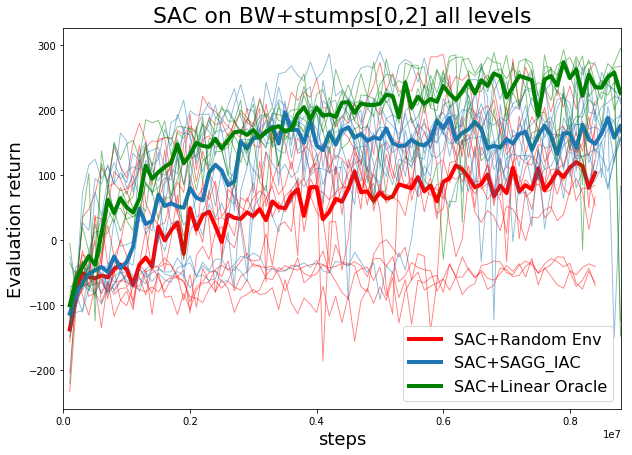

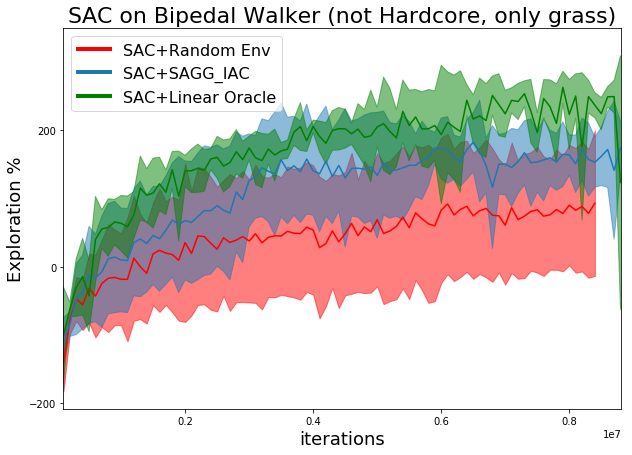

In [47]:

f, ax = plt.subplots(1,1,figsize=(10,7))
ax = [ax]
fm, axm = plt.subplots(1,1,figsize=(10,7))
axm = [axm]
for i,(m_id,d) in enumerate(models_saves.items()):
    print(m_id)
    runs_data = d['data']
    #print(len(runs_data))
    ys = []
    for run in runs_data:  
        #print(list(run))
        data = run['evaluation return']
        #data = run['AverageEpRet']
        #print(list(run))
        episodes = np.array(run['total timesteps'])
        #print(run['Time'][-1])
        #print(len(run['env_params_train']))
        #print(len(run['env_params_test']))
        ys.append(data)
        #clean data    
        label = labels[m_id] if m_id in labels else m_id
    min_len = 999999
    for y in ys:
        if len(y) < min_len:
            min_len = len(y)
    ys_same_len = []
    for y in ys:
        ys_same_len.append(y[0:min_len])
    episodes = episodes[0:min_len]
    plot_all_and_median(0, ax[0], episodes,ys_same_len,colors[m_id],label,
                        title="SAC on BW+stumps[0,2] all levels", legend=True)
    f.savefig('graphics/SAC_BW_stumps[0,2]_all_levels.png')
    plot_with_std(0, axm[0],episodes,np.mean(ys_same_len,axis=0),np.std(ys_same_len,axis=0),colors[m_id],colors[m_id],label,
                   legend=True, title="SAC on Bipedal Walker (not Hardcore, only grass)")
    
get_welch(algo_0='sac_wstumpnoinputlvls_oracle4', algo_1='sagg_sac2')
        
#plt.savefig("graphics/sac_walker_small_vs_big_nets.png", bbox_inches='tight')

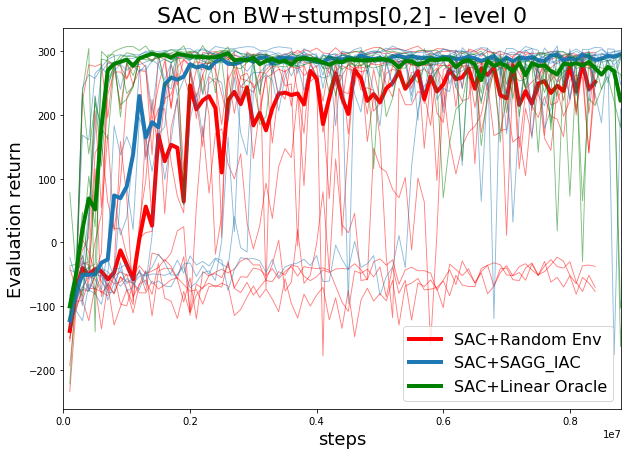

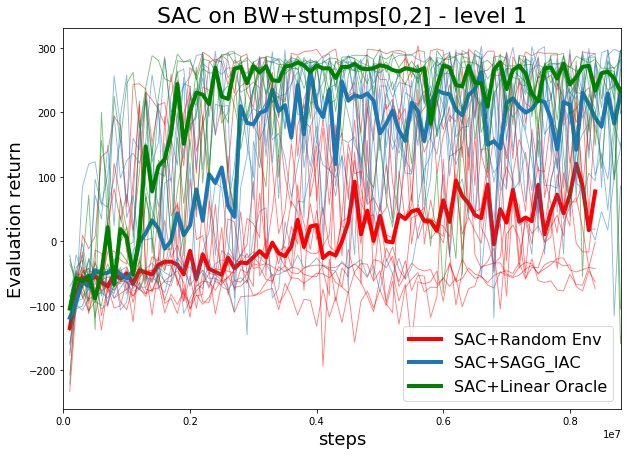

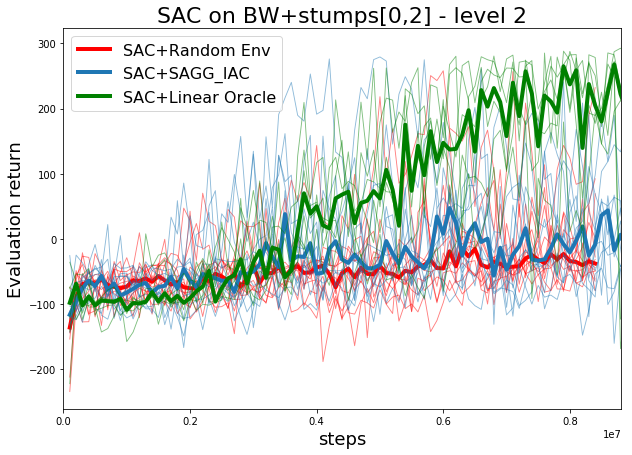

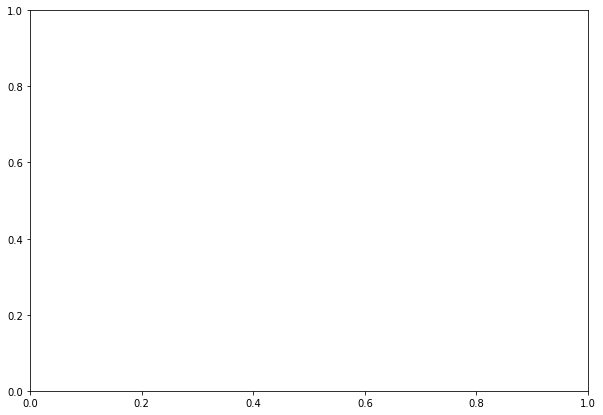

In [45]:
nb_levels = 3
nb_tests_per_epochs = 15
level_step = int(nb_tests_per_epochs / nb_levels)
def get_level_ys(runs_data, min_len):
    level_ys = {}
    for i in range(nb_levels):
        level_ys[str(i)] = []
    nb_tests = len(runs_data[0]['env_test_rewards'][0:min_len*nb_tests_per_epochs])
    nb_steps = nb_tests/nb_tests_per_epochs
    steps = np.arange(0,nb_tests,nb_tests_per_epochs)
    #collect raw perfs
    for run in runs_data:
        raw_y = run['env_test_rewards'][0:min_len*nb_tests_per_epochs]
        level_y = {}
        for i in range(nb_levels):
            level_y[str(i)] = []
        for j in steps:
            #print(j)
            test_batch = raw_y[j:j+nb_tests_per_epochs]
            #print(test_batch)
            last_idx = 0
            for i in range(nb_levels):
                level_y[str(i)].append(np.mean(test_batch[last_idx:last_idx+level_step]))
                last_idx = last_idx+level_step
        for k in level_ys.keys():
            level_ys[k].append(level_y[k])
                
    return level_ys
    
    
f0, ax0 = plt.subplots(1,1,figsize=(10,7))
f1, ax1 = plt.subplots(1,1,figsize=(10,7))
f2, ax2 = plt.subplots(1,1,figsize=(10,7))
ax = [ax0,ax1,ax2]
fm, axm = plt.subplots(1,1,figsize=(10,7))
axm = [axm]
for i,(m_id,d) in enumerate(models_saves.items()):
    runs_data = d['data']
    ys = []
    for run in runs_data:  
        data = run['evaluation return']
        episodes = np.array(run['total timesteps'])
        ys.append(data) 
    #clean data   
    min_len = 999999
    for y in ys:
        if len(y) < min_len:
            min_len = len(y)
    ys_same_len = []
    for y in ys:
        ys_same_len.append(y[0:min_len])
    episodes = episodes[0:min_len]
    level_ys = get_level_ys(runs_data, min_len)
    #print(len(ys0[0]))
    #print(len(episodes))
    label = labels[m_id] if m_id in labels else m_id
    for k,lvl_ys in level_ys.items():
            plot_all_and_median(0, ax[int(k)], episodes,lvl_ys,colors[m_id],label=label,
                                title="SAC on BW+stumps[0,2] - level "+k, legend=True)
f0.savefig('graphics/SAC_BW_stumps[0,2]_level0.png')
f1.savefig('graphics/SAC_BW_stumps[0,2]_level1.png')
f2.savefig('graphics/SAC_BW_stumps[0,2]_level2.png')
    
#             plot_with_std(0, axm[0],episodes,np.mean(lvl_ys,axis=0),np.std(lvl_ys,axis=0),color[i+int(k)],color[i+int(k)],label,
#                            legend=True, title="SAC on Bipedal Walker (not Hardcore, only grass)")


In [ ]:
# SINGLE PLOT


#PLOT ALL + MEDIAN
ys = []


for run in models_saves['SAC spinup']['data']:
    
    data = run['evaluation return']
    episodes = np.array(run['total timesteps'])
    #print(episodes)
    ys.append(data)
title = ''
#y_min=-100, y_max=330
print(ys)

plot_all_and_median(0, ax[0], episodes,ys,None,'SAC',
                    title='SAC from spinningup',
                    legend=False)
plt.savefig("tmp_immm.png", bbox_inches='tight')

In [40]:
from param_env_utils.active_goal_sampling import SAGG_RIAC
import matplotlib.patches as patches
from param_env_utils.imgep_utils.gep_utils import scale_vector
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.colorbar as cbar

def scatter_plot_gif(data,nb_steps=50, name='test'):
    length = len(data)
    step_size = int(length / nb_steps)
    print("Making an exploration GIF of {} steps".format(nb_steps))
    filenames = []
    for i,max_episodes in enumerate(np.arange(step_size,length+step_size,step_size)):
        scatter_plot(data[0:max_episodes])
        f_name = "graphics/gifs/scatter_{}.png".format(i)
        plt.savefig(f_name, bbox_inches='tight')
        filenames.append(f_name)
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('graphics/scatter_gif_{}.gif'.format(name), images, duration=0.3)

def scatter_plot(data, ax=None, emph_data=None):
    if ax is None:
        f, ax = plt.subplots(1,1,figsize=(7,7))
    Xs,Ys = [d[0] for d in data], [d[1] for d in data]
    emphXs,emphYs = [d[0] for d in emph_data], [d[1] for d in emph_data]
    ax.plot(Xs,Ys,'r.',markersize=2)
    ax.axis('equal')
    ax.set_xlim(xmin=0,xmax=2.0)
    ax.set_ylim(ymin=0,ymax=2.0)
    if emph_data is not None:
        ax.plot(emphXs,emphYs,'b.',markersize=5)
    ax.set_xlabel('min stump height', fontsize=20)
    ax.set_ylabel('max stump height', fontsize=20)

for i,(m_id,d) in enumerate(models_saves.items()):
    print(m_id)
    if m_id != "sac_wstumpnoinputlvls_oracle":
        continue
    runs_data = d['data']
    ys = []
    for run in runs_data:
        #print(list(run))
            env_params_train = run['env_params_train']
            env_params_test = run['env_params_test']
            scatter_plot_gif(env_params_train,name=m_id+str(i))
            print(len(env_params_train))
            scatter_plot(env_params_train)
            plt.show()
        
def plot_regions(boxes, interests, ax=None):
    # Create figure and axes
    if ax==None:             
        f, ax = plt.subplots(1,1,figsize=(8,7))
    # Add the patch to the Axes
    for b,ints in zip(boxes,interests):
        #print(b)
        lx,ly = b.low
        hx,hy = b.high
        c = plt.cm.jet(ints)
        rect = patches.Rectangle([lx,ly],(hx - lx),(hy - ly),linewidth=3,edgecolor='white',facecolor=c)
        ax.add_patch(rect)
        #plt.Rectangle([lx,ly],(hx - lx), (hy - ly))

    cax, _ = cbar.make_axes(ax) 
    cb = cbar.ColorbarBase(cax, cmap=plt.cm.jet) 
    cb.set_label('Mean Competence Progress')
    ax.axis('equal')
    ax.set_xlim(xmin=0,xmax=2)
    ax.set_ylim(ymin=0,ymax=2)
    ax.set_xlabel('min stump height', fontsize=20)
    ax.set_ylabel('max stump height', fontsize=20)

def region_plot_gif(all_boxes, interests, iterations, goals,
                    gifname='saggriac', rewards=None, ep_len=None):
    plt.ioff()
    print("Making an exploration GIF: "+gifname)
    filenames = []
    images = []
    steps = []
    mean_rewards = []
    plot_step = 250
    for i in range(len(goals)):
        if i>0 and (i%plot_step == 0):  
            f, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(27,7))
            ax = [ax0,ax1, ax2]
            scatter_plot(goals[0:i], ax=ax[0], emph_data=goals[i-plot_step:i])
            idx = 0
            cur_idx = 0
            for j in range(len(all_boxes)):
                if iterations[j] > i:
                    break
                else:
                    cur_idx = j

            #ADD TRAINING CURVE
            ax[2].set_ylabel('Train return', fontsize=18)
            steps.append(sum(ep_len[0:i]))
            mean_rewards.append(np.mean(rewards[i-plot_step:i]))
            ax[2].plot(steps,mean_rewards)
            
            plot_regions(all_boxes[cur_idx], interests[cur_idx],ax=ax[1])
            f_name = "graphics/gifs/scatter_{}.png".format(i)
            plt.suptitle('Episode {}'.format(i), fontsize=20)
            plt.savefig(f_name, bbox_inches='tight')
            plt.close(f)
            filenames.append(f_name)
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('graphics/{}.gif'.format(gifname), images, duration=0.3)

sac_lgwidestumpnoinputlevels
sagg_sac2
sac_wstumpnoinputlvls_oracle4


In [79]:
import importlib
import param_env_utils.active_goal_sampling as gsamp
importlib.reload(gsamp)
#Testing sagg_iac
print(list(models_saves))
data = models_saves['sac_lgwidestumpnoinputlevels']['data'][5]
print(len(data['env_params_train']))
print(len(data['env_train_rewards']))
env_goals = data['env_params_train']
reward_outcome = data['env_train_rewards']
#scatter_plot(env_goals)
ndims = 2
SAGG = gsamp.SAGG_RIAC(np.array([0.0]*ndims), np.array([2.0]*ndims))
all_boxes = []
iterations = []
interests = []
plot = False
for i,(g,o) in enumerate(zip(env_goals,reward_outcome)):
    split, _ = SAGG.update([np.array(g)], None, continuous_competence=[np.interp(o, (-200, 300), (0,1))])
    if split:
        boxes = SAGG.region_bounds
        interest = SAGG.interest
        if plot:
            plot_regions(boxes, interest)
            plt.show()
        interests.append(copy.copy(interest))
        iterations.append(i)
        all_boxes.append(copy.copy(boxes))

['sac_lgwidestumpnoinputlevels']
6632
6631


In [41]:
#scatter_plot(env_goals)
print(list(models_saves))
sagg_model_name = 'sagg_sac2'
print(models_saves[sagg_model_name]['data'][0]['config']['seed'])
for i in range(len(models_saves[sagg_model_name]['data'])):
    all_boxes = models_saves[sagg_model_name]['data'][i]['all_boxes']
    split_iterations = models_saves[sagg_model_name]['data'][i]['split_iterations']
    env_train_rewards = models_saves[sagg_model_name]['data'][i]['env_train_rewards']
    all_interests = models_saves[sagg_model_name]['data'][i]['all_interests']
    env_goals = models_saves[sagg_model_name]['data'][i]['env_params_train']
    ep_len = models_saves[sagg_model_name]['data'][i]['env_train_len']
    if len(all_boxes) == 0:
        print('abort {}'.format(i))
        continue
    region_plot_gif(all_boxes, all_interests, split_iterations, env_goals,
                   gifname='onlineSAGG'+str(i), rewards=env_train_rewards, ep_len=ep_len)

['sac_lgwidestumpnoinputlevels', 'sagg_sac2', 'sac_wstumpnoinputlvls_oracle4']
40
Making an exploration GIF: onlineSAGG0
Making an exploration GIF: onlineSAGG1
Making an exploration GIF: onlineSAGG2
Making an exploration GIF: onlineSAGG3
Making an exploration GIF: onlineSAGG4
Making an exploration GIF: onlineSAGG5
Making an exploration GIF: onlineSAGG6
Making an exploration GIF: onlineSAGG7
Making an exploration GIF: onlineSAGG8
Making an exploration GIF: onlineSAGG9
Making an exploration GIF: onlineSAGG10


![](graphics/exploration0.gif)
![](graphics/exploration1.gif)


![SegmentLocal](graphics/lpSAGG.gif "learning progress")
![SegmentLocal](graphics/competenceSAGG.gif "competence")
![SegmentLocal](graphics/onlineSAGG0.gif "competence")
![SegmentLocal](graphics/onlineSAGG1.gif "competence")
![SegmentLocal](graphics/onlineSAGG2.gif "competence")
![SegmentLocal](graphics/onlineSAGG3.gif "competence")
![SegmentLocal](graphics/onlineSAGG4.gif "competence")
![SegmentLocal](graphics/onlineSAGG5.gif "competence")
![SegmentLocal](graphics/onlineSAGG6.gif "competence")
![SegmentLocal](graphics/onlineSAGG7.gif "competence")
![SegmentLocal](graphics/onlineSAGG8.gif "competence")
![SegmentLocal](graphics/onlineSAGG9.gif "competence")
![SegmentLocal](graphics/onlineSAGG10.gif "competence")
![SegmentLocal](graphics/onlineSAGG11.gif "competence")

In [ ]:
lidar = []
self.lidar[i].fraction = 1.0
            self.lidar[i].p1 = pos
            self.lidar[i].p2 = (
                pos[0] + math.sin(1.5*i/10.0)*LIDAR_RANGE,
                pos[1] - math.cos(1.5*i/10.0)*LIDAR_RANGE)

In [ ]:
metrics_mean_explo = [mean_a_explo, mean_p_explo, mean_s_explo, mean_b_explo, mean_c_explo] 
metrics_std_explo = [std_a_explo, std_p_explo, std_s_explo, std_b_explo, std_c_explo]
plot_steps = np.arange(0,nb_episodes+step_size,step_size)
colors = ['red','blue','green','magenta','black','cyan','orange']
shades_colors = ['lightsalmon','skyblue','lightgreen','violet']
title_info = ["agent", "pickaxe", "shovel", "blocks", "cart"]
model_names = titles
metric = ["agent","pickaxe","shovel","blocks","cart"]
maxes=[85,85,85,100,85]

# # Averaged plots
# f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5,figsize=(20,4))
# ax = (ax0, ax1, ax2, ax3, ax4)
# print(model_filenames)
# for j, (models_mean_explo, models_std_explo) in enumerate(zip(metrics_mean_explo, metrics_std_explo)):
#     for i,(mean_explo, std_explo) in enumerate(zip(models_mean_explo, models_std_explo)):
#         y = mean_explo
#         err = std_explo
#         title = ''
#         plot_with_std(j, ax[j], plot_steps,y,err,colors[i],shades_colors[i],model_names[i],
#                       y_min=0,y_max=maxes[j], title=title+title_info[j], legend=True)
        
# #plt.savefig("graphics/grid_cell_exploration_mmc.pdf", bbox_inches='tight')
# #plt.savefig("grid_cell_exploration_samebt.png", bbox_inches='tight')
# plt.show()

#PLOT ALL + MEDIAN
all_explo = [all_a_explo, all_p_explo, all_s_explo, all_b_explo, all_c_explo]
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5,figsize=(20,4))
ax = (ax0, ax1, ax2, ax3, ax4)
print(model_filenames)
for j, models_all_explo in enumerate(all_explo):
    for i, explo in enumerate(models_all_explo):
        ys = explo
        title = ''
        plot_all_and_median(j, ax[j], plot_steps,ys,colors[i],shades_colors[i],model_names[i],
                      y_min=0,y_max=maxes[j], title=title+title_info[j], legend=True)
plt.savefig("graphics/grid_cell_exploration_mmc.png", bbox_inches='tight')


In [ ]:
def plot_with_std(x,y,err,color,shade_color,label,y_min,y_max):
    plt.plot(x,y, color=color, label=label,linewidth=1.5)
    plt.fill_between(x,y-err,y+err,color=shade_color,alpha=0.5)
    leg = plt.legend(loc='lower right')
    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)
    plt.xlabel('episodes')
    plt.ylabel('exploration %')
    if y_min is not None:
        plt.ylim(ymin=y_min,ymax=y_max)
    

labels = ['RND','F-RGB','RMB','AMB']
shades_colors = ['lightsalmon','skyblue','lightgreen','violet']
print("agent exploration")
x = np.arange(0,nb_episodes+step_size,step_size)
for i in range(nb_models):
    print(std_a_explo[i,-1])
    y = mean_a_explo[i,:]
    err = std_a_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_agent_pos_expl.pdf", bbox_inches='tight')
plt.show()

print("shovel exploration")
x = np.arange(0,nb_episodes+step_size,step_size)
for i in range(nb_models):
    print(std_s_explo[i,-1])
    y = mean_s_explo[i,:]
    err = std_s_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_agent_pos_expl.pdf", bbox_inches='tight')
plt.show()

print("pickaxe exploration")
x = np.arange(0,nb_episodes+step_size,step_size)
for i in range(nb_models):
    print(std_p_explo[i,-1])
    y = mean_p_explo[i,:]
    err = std_p_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_agent_pos_expl.pdf", bbox_inches='tight')
plt.show()

print("cart")
for i in range(nb_models):
    print(std_c_explo[i,-1])
    y = mean_c_explo[i,:]
    err = std_c_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_cart_pos_expl.pdf", bbox_inches='tight')
plt.show()

print("blocks")
for i in range(nb_models):
    y = mean_b_explo[i,:]
    err = std_b_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_bread_pos_expl.pdf", bbox_inches='tight')
plt.show()
#plt.plot(mean_a_explo, color='red', label=m_name.replace('_',' '))
#plt.plot(mean_c_explo, color='blue', label=m_name.replace('_',' '))
#plt.plot(mean_b_explo, color='green', label=m_name.replace('_',' '))
        

In [ ]:
def plot_interests(ax,subplot_nb,interest_dict, legend=True, labels=None):
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    colors = ['red','blue','green','magenta','black',
              'cyan','orange','powderblue','salmon','aqua','darkolivegreen',
             'orchid','indigo','saddlebrown']
    for i,(name,interests) in enumerate(sorted(interest_dict.items())):
        #print(name)
        if labels is not None:
            ax.plot(interests, color=colors[i], label=labels[i],linewidth=1.5)
        else:
            ax.plot(interests, color=colors[i], label=name.replace('_',' '),linewidth=1.5)
    if subplot_nb == 0:
        ax.set_ylabel('Interest', fontsize=18)
        
    ax.set_xlabel('Iterations', fontsize=18)
    if legend:
        leg = ax.legend(loc='upper left')
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)

short_labels = ['agent','bread','cart','distr 1','distr 2','distr 3', 'distr 4']

# Plot interest curves:

for i in range(9):
    f, (ax0, ax1) = plt.subplots(1,2,figsize=(16,4))
    ax = (ax0, ax1)
    ints = saves[model_filenames[2]][i]['interests']
    plot_interests(ax[0],0,ints,legend=True,labels=None)
#plt.savefig("aaa_newold_interests_samebt.png", bbox_inches='tight')




In [ ]:
# PLOT 3 SAMPLES OF AMB INTERESTS
f, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(24,4))
ax = (ax0, ax1, ax2)
for i,run_nb in enumerate([0,3,8]):
    ints = saves[model_filenames[2]][run_nb]['interests']
    plot_interests(ax[i],i,ints,legend=True,labels=None)
plt.savefig("graphics/interest_curves_amb_mmc.png", bbox_inches='tight')


In [ ]:
# Plot competence evolution for amb runs
f, (ax0, ax1) = plt.subplots(1,2,figsize=(20,4))
ax = (ax0, ax1)
m_names = ['pickaxe_end_pos']

for i in range(1):
    dists = {}
    for m_name in m_names:
        
        all_goals = saves[model_filenames[2]][1]['modules'][m_name].generated_goals
        all_outs = saves[model_filenames[2]][1]['modules'][m_name].observed_outcomes
        print(len(all_goals))
        print(len(all_outs))
        goals = np.array([all_goals[k-1] for k in range(5,len(all_goals),5)])
        outs = np.array([all_outs[k-1] for k in range(5,len(all_outs),5)])
        print(goals[-5:])
        print(outs[-5:])
        d = np.linalg.norm(goals - outs,axis=1)
        dists[m_name] = d
    #euc_d2 = np.linalg.norm(goals - outs,axis=1)
#     print(goals[0:3])
#     print(outs[0:3])
#     print(dists[0:3])
#     print(euc_d[0:3])
#     print(euc_d2[0:3])
#     print("h")
    plot_interests(ax[i],i,dists,legend=False,labels=None)

In [ ]:
# get interest curves names:
labels_2 = [s.replace('_',' ') for s in np.unique(saves[model_filenames[3]][0]['choosen_modules'])]

#labels = ['agent final position','bread final count','cart final position',
#               'fixed distractor 1 final position','fixed distractor 2 final position','moving distractor 1 final position', 'moving distractor 2 final position']
colors = ['red','blue','green','magenta','black','cyan','orange']

fig = pylab.figure()
figlegend = pylab.figure(figsize=(3.5,2))
ax = fig.add_subplot(111)
line_data = []
#for i in range(len(labels)):
#    line_data.append([range(10), pylab.randn(10), colors[i]])
print(len(labels_2))
if len(labels_2) == 3:
    lines = ax.plot(range(10),pylab.randn(10),colors[0],
                    range(10),pylab.randn(10),colors[1],
                    range(10),pylab.randn(10),colors[2])
elif len(labels_2) == 5:
    lines = ax.plot(range(10),pylab.randn(10),colors[0],
                    range(10),pylab.randn(10),colors[1],
                    range(10),pylab.randn(10),colors[2],
                    range(10),pylab.randn(10),colors[3],
                    range(10),pylab.randn(10),colors[4])
    
leg = figlegend.legend(lines, labels_2[:len(labels_2)], 'center')
for legobj in leg.legendHandles:
            legobj.set_linewidth(6.0)
        
figlegend.show()
figlegend.savefig('legend.png')

In [ ]:
# Time complexity analysis
for m_name, m_id in zip(model_full_names,model_filenames):
    print(m_id)
    b_k = saves[m_id][4]
    if 'runtimes' in b_k:
        rts = b_k['runtimes']
        #print(rts['produce'][-100:])
        plt.plot(rts['produce'],label='choose policy')
        plt.plot(rts['run'],label='run episode')
        plt.plot(rts['perceive'],label='add to memory')
        plt.legend()
        plt.ylabel('seconds')
        plt.xlabel('episodes')
    plt.savefig("time_complexity.png")
    plt.show()


In [ ]:
Xs,Ys = [],[]
plt.figure()
epsilon = 1e-3
for i in range(500):
    random_stump_height = (np.random.random(2) * 2.0)
    random_stump_height.sort()
    if np.abs(random_stump_height[1] - random_stump_height[0]) < epsilon:
        random_stump_height[1] += epsilon
    Xs.append(random_stump_height[0])
    Ys.append(random_stump_height[1])
plt.plot(Xs,Ys,'r.')
plt.axis('equal')
plt.show()

Xs,Ys = [],[]
plt.figure()
epsilon = 1e-3
for i in range(500):
    min_stump_height = np.random.uniform(0,2.0)
    max_stump_height = np.random.uniform(min_stump_height,2.0)
    Xs.append(min_stump_height)
    Ys.append(max_stump_height)
plt.plot(Xs,Ys,'r.')
plt.axis('equal')
plt.show()